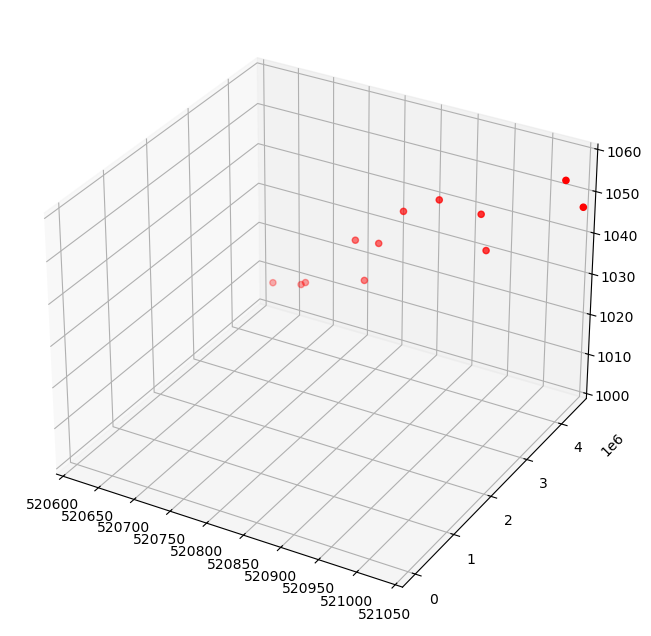

In [1]:
#Part 1 
#This code extracts feature points from drone images, calculates the 3D positions of these points, and then visualizes these positions within a certain range.

import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import exifread

# We define the "load_drone_images" function that we will use to load drone images from a folder and determine the file types that can be loaded.
def load_drone_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            images.append(image)
    return images

# We define the "extract_camera_parameters" function to extract camera parameters (focal lengths and sensor widths) from the EXIF metadata of an image.
def extract_camera_parameters(image_path):
    with open(image_path, 'rb') as f:
        tags = exifread.process_file(f, details=False)
        focal_length_x = tags['EXIF FocalLength'].values[0].num
        focal_length_y = tags['EXIF FocalLength'].values[1].num
        sensor_width_x = tags['EXIF FocalPlaneXResolution'].values[0].num
        sensor_width_y = tags['EXIF FocalPlaneYResolution'].values[0].num
        fx = focal_length_x * (sensor_width_x / image.shape[1])
        fy = focal_length_y * (sensor_width_y / image.shape[0])
        return fx, fy

# We define Ground Control Points
control_points = np.array([
    [520922.734, 4417264.700, 1040.468],
    [520748.548, 4417394.726, 1025.609],
    [520628.466, 4417357.581, 1008.779],
    [520670.095, 4417249.077, 1010.404],
    [520781.742, 4417284.137, 1026.428],
    [520865.230, 4417148.025, 1041.239],
    [520676.473, 4417104.079, 1011.236],
    [520761.780, 4416936.747, 1016.076],
    [520816.033, 4417024.802, 1036.072],
    [520930.735, 4416936.812, 1031.971],
    [521057.879, 4417049.691, 1048.639],
    [521033.776, 4417155.331, 1053.884]
])

#Uses it to load drone images from a specific folder.
image_folder_path =  r"C:\Users\kubra\OneDrive\Masaüstü\project\dron_images"
drone_images = load_drone_images(image_folder_path)

# Creates an empty point cloud.
point_cloud = np.empty((0, 3))

# For each image
for image in drone_images:
    #Creating a grayscale version from the drone image and then extracting feature points and descriptions using SIFT (Scale-Invariant Feature Transform) algorithm on this gray image.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    #It creates the file path of the image and extracts the camera parameters (focal lengths and sensor widths) on that image.
    image_path = os.path.join(image_folder_path,  r"C:\Users\kubra\OneDrive\Masaüstü\project\dron_images\100_0005_0029.JPG")
    fx, fy = extract_camera_parameters(image_path)
    #By default, it accepts that the principal point is in the middle of the image
    cx, cy = image.shape[1] / 2, image.shape[0] / 2  

    #Calculates 3D positions for each feature point and adds these positions to a NumPy array named point_cloud
    for kp in keypoints:
        u, v = kp.pt
        depth = '38,63' # undulation value of its location
        point_3d = np.dot(np.linalg.inv(np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])), np.array([u, v, 1]) * float(depth))
        point_cloud = np.vstack([point_cloud, point_3d])

# Visualize the point cloud
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])
ax.scatter(control_points[:, 0], control_points[:, 1], control_points[:, 2], c='red', marker='o')  # Control points in red

#specifies the ranges to display on the x, y, and z axes of a graphics window that visualizes the created 3D point cloud.(for example)
min_x, max_x = 520600, 521050
min_z, max_z = 1000, 1060

ax.set_xlim([min_x, max_x])
ax.set_zlim([min_z, max_z])

plt.show()

In [2]:
# Part 2
#This Python code takes a LiDAR (Light Detection and Ranging) LAS file (point cloud) and creates a Digital Elevation Model (DEM) using this point cloud.

import laspy
from osgeo import gdal
import numpy as np

def las_to_dem(las_path, dem_path):
    # Read LAS file
    las_file = laspy.file.File(las_path, mode='r')

    # Extract point cloud data
    x = las_file.x
    y = las_file.y
    z = las_file.z

    # Extract unique positions from x and y coordinates in the LAS file and their indexes in the original directory.
    unique_xy = np.column_stack((x, y))
    unique_xy, unique_indices = np.unique(unique_xy, axis=0, return_index=True)

    # DEM (Digital Elevation Model) defines the properties of the raster data and determines the dimensions, resolution and layout of the raster to be created.
    dem_width = 1000  
    dem_height = 1000  
    dem_resolution = 1.0  
    dem_geotransform = (unique_xy[:, 0].min(), dem_resolution, 0, unique_xy[:, 1].max(), 0, -dem_resolution)
    
    
#Creates a NumPy array for DEM (Digital Elevation Model) and determines the data type of the array as 32-bit float. 
#The array created will have the specified dimensions and data type and will fill all values with np.nan.
#Creating a digital elevation model by adding the z data in the LAS file. The np.full function is used to create an array of specified dimensions and filled with the specified value.
    dem_array = np.full((dem_height, dem_width), np.nan, dtype=np.float32)

    
    #It adds the z (height) values taken from the point cloud to the created DEM array. The x and y coordinates of each point are unique coordinates in the unique_xy array. These coordinates are transformed into pixel coordinates of the DEM raster using the previously determined dem_geotransform parameters.
    for i, index in enumerate(unique_indices):
        dem_array[int((unique_xy[i, 1] - dem_geotransform[3]) / -dem_geotransform[5]),
                  int((unique_xy[i, 0] - dem_geotransform[0]) / dem_geotransform[1])] = z[index]

    # Creates a raster file in GeoTIFF format using the GDAL (Geospatial Data Abstraction Library) library
    driver = gdal.GetDriverByName("GTiff")
    dem_dataset = driver.Create(dem_path, dem_width, dem_height, 1, gdal.GDT_Float32)
    dem_dataset.SetGeoTransform(dem_geotransform)

    # Used to define the geographic projection of the DEM raster file and then write actual elevation data to that file
    dem_dataset.SetProjection("EPSG:5254")  # UTM Zone 30N

    dem_band = dem_dataset.GetRasterBand(1)
    dem_band.WriteArray(dem_array)
    dem_band.FlushCache()

    # Close datasets
    dem_dataset = None
    las_file.close()

# Example usage
las_file_path = r"C:\Users\kubra\OneDrive\Masaüstü\project\bilecik_datas\pointcloud.las"
dem_output_path = r"C:\Users\kubra\OneDrive\Masaüstü\pointcloud_to_dem.tif"

las_to_dem(las_file_path, dem_output_path)

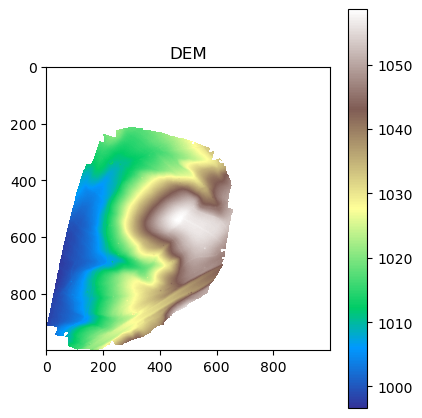

In [4]:
# Part 3
#This code reads the DEM data in the specified TIFF file, makes a color visualization and shows it to the user.

import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to TIFF file
tiff_path = r"C:\Users\kubra\OneDrive\Masaüstü\pointcloud_to_dem.tif"

# Open TIFF file
with rasterio.open(tiff_path) as src:
    # Read altitude data
    dem_data = src.read(1)

    # Increase the size of the output
    plt.figure(figsize=(12, 6))

    
    #It creates a figure consisting of three subplots using the 
    #Matplotlib library and visualizes the digital elevation model (DEM) in the first subplot.
    
    plt.subplot(1, 3, 1)
    plt.title("DEM")
    plt.imshow(dem_data, cmap='terrain', vmin=996.64, vmax=1058.63)
    plt.colorbar(shrink=0.7)

    plt.tight_layout()
    plt.show()


C:\Users\kubra\AppData\Local\Temp\ipykernel_15024\3605175602.py:42: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


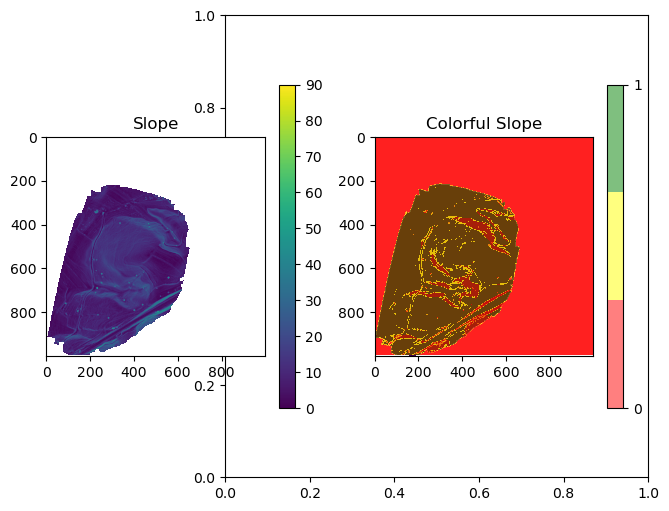

In [15]:
# Part 4
#In addition to visualizing slope data, this code creates a map colored according to specific slope thresholds.

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Path to TIFF file
dem_tiff_path = r"C:\Users\kubra\OneDrive\Masaüstü\pointcloud_to_dem.tif"
slope_tiff_path = r"C:\Users\kubra\AppData\Local\Temp\processing_bVNmvT\1afe2aa8a4294dc299ba65a064ed1500\OUTPUT.tif"

# Open TIFF file
with rasterio.open(dem_tiff_path) as dem_src:
    dem_data = dem_src.read(1, masked=True)

with rasterio.open(slope_tiff_path) as slope_src:
    slope_data = slope_src.read(1, masked=True)

# Create color scale for colored slope map
cmap = ListedColormap(['red', 'yellow', 'green'])

# Create a subplot
plt.figure(figsize=(12, 6))

#It visualizes slope data by creating a map colored according to specific slope categories.
plt.subplot(1, 2, 2)
plt.subplot(1, 3, 2)
plt.title("Slope")
plt.imshow(slope_data, cmap='viridis', vmin=0, vmax=90)
plt.colorbar(shrink=0.7)

# Visualize the map colored by slope categories
plt.subplot(1, 3, 3)
plt.title("Colorful Slope")
plt.imshow(dem_data, cmap='viridis', vmin=dem_data.min(), vmax=dem_data.max())
plt.imshow(slope_data > 30, cmap=cmap, alpha=0.5)
plt.imshow((slope_data <= 30) & (slope_data > 15), cmap=cmap, alpha=0.5)
plt.imshow(slope_data <= 15, cmap=cmap, alpha=0.5)
plt.colorbar(shrink=0.7, ticks=[0, 1, 2])

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

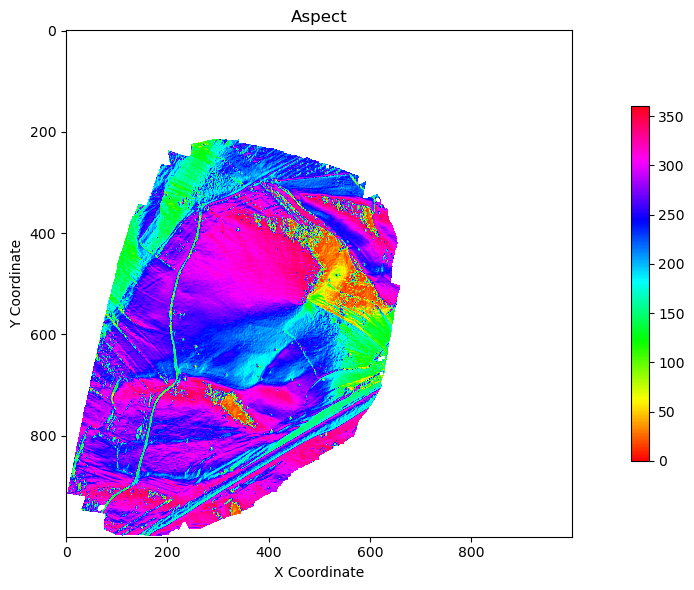

In [10]:
# Part 5
#This code reads the aspect data of a specific geographical area and visualizes it as a colored map.

import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to TIFF file
tiff_path = r"C:\Users\kubra\AppData\Local\Temp\processing_bVNmvT\068cbdf608b64dd39e58ac457194a741\OUTPUT.tif"

# Open TIFF file
with rasterio.open(tiff_path) as src:
    # Read aspect data
    # masked=True reads No-Data values by masking them
    aspect_data = src.read(1, masked=True)  # masked=True, No-Data değerlerini maskeleyerek okur

    # Create X and Y values
    X = np.linspace(src.bounds.left, src.bounds.right, src.width)
    Y = np.linspace(src.bounds.bottom, src.bounds.top, src.height)

    #It creates a Matplotlib figure and visualizes the aspect data with a specific color map and color range.
    plt.figure(figsize=(12, 6))
    plt.figure(figsize=(12, 6))

    plt.title("Aspect")
    plt.imshow(aspect_data, cmap='hsv', vmin=0, vmax=360)  
    plt.colorbar(shrink=0.7)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    plt.tight_layout()
    plt.show()

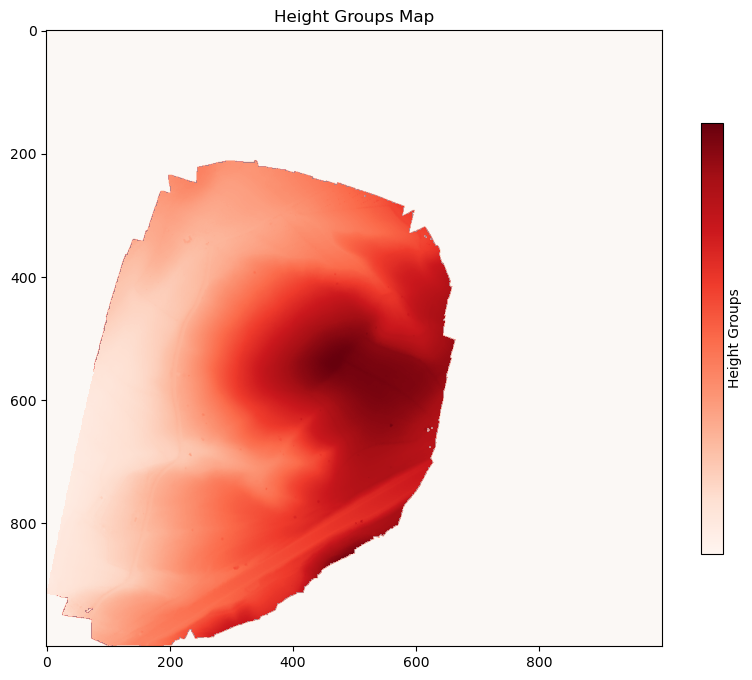

In [6]:
# Part 6 
#This code divides the elevation data in a DEM (Digital Elevation Model) file into specific groups and visualizes these groups with different color maps.

import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to TIFF file
tiff_path = r"C:\Users\kubra\OneDrive\Masaüstü\pointcloud_to_dem.tif"

# Open TIFF file
with rasterio.open(tiff_path) as src:
## Read altitude data
    dem_data = src.read(1)
    
# Specify elevation groups
elevation_min = (dem_data >= 0) & (dem_data < 100)
elevation_middle = (dem_data >= 100) & (dem_data < 500)
elevation_max = dem_data >= 1000

# Create color maps
cmap_min = plt.cm.Blues
cmap_middle = plt.cm.Greens
cmap_max = plt.cm.Reds

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each elevation group with distinct colors
ax.imshow(elevation_min, cmap=cmap_min, alpha=0.5, label='Min Height ')
ax.imshow(elevation_middle, cmap=cmap_middle, alpha=0.5, label='Middle Height')
ax.imshow(elevation_max, cmap=cmap_max, alpha=0.5, label='Max Height')

# Title and colorbar
ax.set_title("Height Groups Map")
cbar = plt.colorbar(ax.imshow(dem_data, cmap=cmap_max), ax=ax, shrink=0.7, ticks=[0, 1, 2], label='Height Groups')


# Show the plot
plt.show()
